https://www.kaggle.com/c/dogs-vs-cats/data

## Configuration
for more, check https://github.com/gianfa/fastai_notes/blob/master/Fastai_Colab_snippets.ipynb

In [1]:
#Mount the drive from Google to save the model
from google.colab import drive
drive.mount('/gdrive')
colab_root = '/../content'
drive_root = '/gdrive/My Drive/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# installs pytorch
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip install torchvision  
import torch
# fixes and other installations
!pip install image
!pip uninstall fastai
!pip uninstall Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

!pip install fastai
!pip install torchtext
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
import matplotlib.pyplot as plt

Uninstalling fastai-1.0.42:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/fastai-1.0.42.dist-info/*
    /usr/local/lib/python3.6/dist-packages/fastai/*
Proceed (y/n)? n
Uninstalling Pillow-5.3.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/PIL/*
    /usr/local/lib/python3.6/dist-packages/Pillow-5.3.0.dist-info/*
Proceed (y/n)? n
5.3.0


In [0]:
# %reload_ext autoreload
# %autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

## Retrieving data

In [0]:
!pip install -q kaggle

In [7]:
kaggle_json = '/gdrive/My Drive/Work/MACHINELEARNING/Dataset/kaggle.json'
print(drive._os.path.exists(kaggle_json))


# The Kaggle API client expects this file to be in ~/.kaggle,
# so copy it there.
# create the dir if not present already
drive._os.mkdir('../root/.kaggle') if not drive._os.path.isdir('../root/.kaggle') else print('.kaggle/ already exists, keep going')
# copy the file
from shutil import copyfile
copyfile(kaggle_json, '../root/.kaggle/kaggle.json')
kaggle_json = '../root/.kaggle/kaggle.json'
print(drive._os.path.exists(kaggle_json))
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
# !rm -rf data


True
.kaggle/ already exists, keep going
True


In [0]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 77.1MB/s]
 99% 269M/271M [00:03<00:00, 78.6MB/s]
100% 271M/271M [00:03<00:00, 77.0MB/s]
 98% 535M/543M [00:06<00:00, 99.5MB/s]
100% 543M/543M [00:06<00:00, 84.5MB/s]


In [8]:
print(drive._os.listdir('.'))

['.config', 'sample_data']


In [0]:
datasetspath = drive_root + 'Work/MACHINELEARNING/Dataset/catsdogs/cvsets/'

In [0]:
drive._os.mkdir(datasetspath)
print(drive._os.listdir( datasetspath ))

[]


In [0]:
import shutil
shutil.move('train.zip', datasetspath)
shutil.move('test1.zip', datasetspath)
shutil.move('sampleSubmission.csv', datasetspath)

'/gdrive/My Drive/Work/MACHINELEARNING/Dataset/catsdogs/train.zip'

In [0]:
folder = datasetspath

In [0]:
import zipfile
for fn in drive._os.listdir(folder):
  if fn[-3:] != 'zip': continue
  with zipfile.ZipFile( folder+fn, "r" ) as zip_ref:
      zip_ref.extractall( folder )
del fn
drive._os.listdir(folder)

In [0]:
fnames = drive._os.listdir(folder+'train')
fnames_cats = [x for x in fnames if x[:3] == 'cat' ]
fnames_dogs = [x for x in fnames if x[:3] == 'dog' ]
fnames_others = [x for x in fnames if x[:3] != 'dog' and x[:3] != 'cat' ]

In [0]:
print(len(fnames_others))
print(fnames_others[:15])
print(len(fnames_cats))
print(fnames_cats[:3])
print(len(fnames_dogs))
print(fnames_dogs[:3])

Move to separate forlders, like imageNet way

In [0]:
train_cats_folder = folder+'train/cats/'
train_dogs_folder = folder+'train/dogs/'

In [0]:
drive._os.mkdir(train_cats_folder)
for fn in fnames_cats:
  shutil.move(folder+'train/'+fn, train_cats_folder+fn)
del fn

drive._os.mkdir(train_dogs_folder)
for fn in fnames_dogs:
  shutil.move(folder+'train/'+fn, train_dogs_folder+fn)
del fn

In [18]:
print('test: ' + str( drive._os.listdir(folder+'test/')[:5]) )
print('train: ' + str( drive._os.listdir(folder+'train/')[:5]) ) # test_cats_folder

test: ['9070.jpg', '9017.jpg', '9111.jpg', '9018.jpg', '9071.jpg']
train: ['cats', 'dogs', 'models']


Loading the databunch

In [0]:
np.random.seed(42)
tfms = get_transforms()
data = ImageDataBunch.from_folder(
    folder+'train/', bs=32,
    size=224, valid_pct = 0.2,
    ds_tfms=tfms, 
).normalize(imagenet_stats)

In [11]:
data.show_batch(rows=4, figsize=(7,6))

NameError: ignored

In [21]:
print(data.classes)
len(data.classes),data.c

['cats', 'dogs']


(2, 2)

## Training: resnet34

In [22]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 97742175.89it/s]


In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


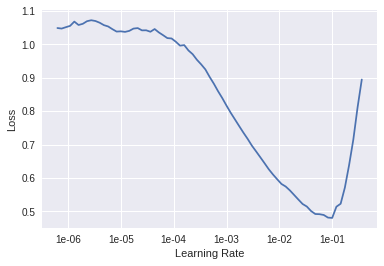

In [0]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(1, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate


AttributeError: ignored

###Save the model

In [0]:
model1_name = 'kaggle_CAD_stage-1'
models_path = drive_root + 'Work/MACHINELEARNING/Dataset/catsdogs/models/'
model1_path = models_path + model1_name

In [0]:
print(learn.save(model1_name, return_path = True))

#### Save the model permanently in your Drive
Run the cell inside this section if you want to permanently save your trained model in your Google Drive folders, otherwise skip it.

In [0]:
model1_perm_path = drive_root + '/' + model1_name
shutil.move(model1_path, model1_perm_path)

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

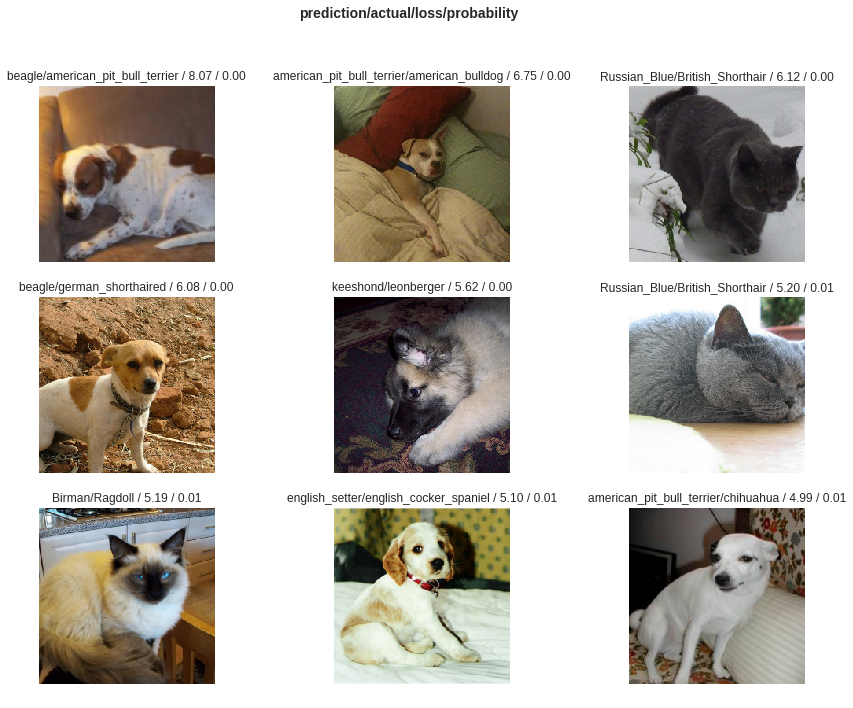

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

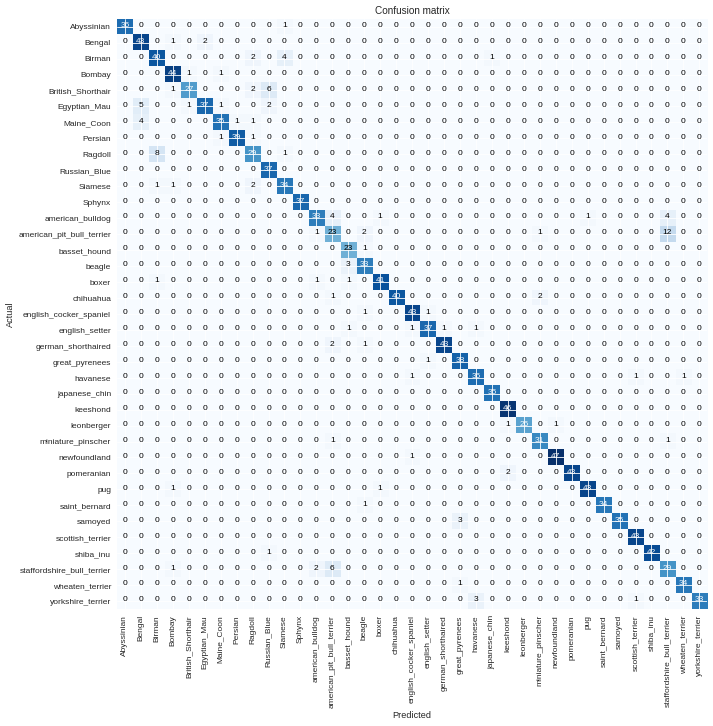

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 12),
 ('Ragdoll', 'Birman', 8),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Birman', 'Siamese', 4),
 ('Maine_Coon', 'Bengal', 4),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('beagle', 'basset_hound', 3),
 ('samoyed', 'great_pyrenees', 3),
 ('yorkshire_terrier', 'havanese', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.558505,0.358435,0.119080


### Load the model

#### opt1: If you saved your model in Drive
Run the cells in this section to get it back

In [0]:
learn.load(model1_perm_path)

####opt2: If you saved your model in default way
Run the cells in this section to load it

In [0]:
learn.load(model1_path);

### Go ahead with the process

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


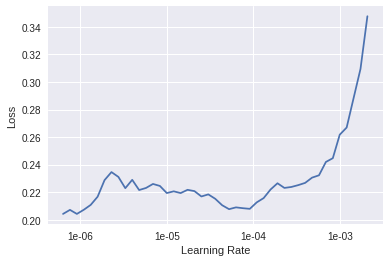

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.229541,0.236935,0.083221
2,0.202260,0.230389,0.077131


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 99237569.19it/s]


epoch,train_loss,valid_loss,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


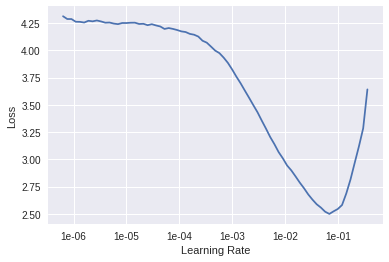

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.723446,0.273188,0.078484
2,0.398676,0.276574,0.089310
3,0.340840,0.229874,0.077131
4,0.259768,0.199049,0.067659
5,0.220103,0.175225,0.053451
6,0.151878,0.178752,0.058863
7,0.112263,0.164402,0.050744
8,0.094971,0.166685,0.052097


### Save the model

In [0]:
model2_name = 'stage-1-50'
model2_path = learn.save(model2_name, return_path = True)
print(model2_path)

#### opt: Save the model permanently in your Drive
Like before, run the cells inside this section if you want to permanently save your trained model in your Google Drive folders, otherwise skip it.

In [0]:
model2_perm_path = drive_root + 'YOUR/DESTINATION/PATH/IN/GOOGLE/DRIVE/' + model2_name
shutil.move(model2_path, model2_perm_path)

### Go ahead with the process

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

### Load the model
Like before...

#### opt1: If you saved your model in Drive
Run the cells in this section to get it back

In [0]:
learn.load(model2_perm_path)

####opt2: If you saved your model in default way
Run the cells in this section to load it

In [0]:
learn.load(model2_path);

### Go ahead with the process

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

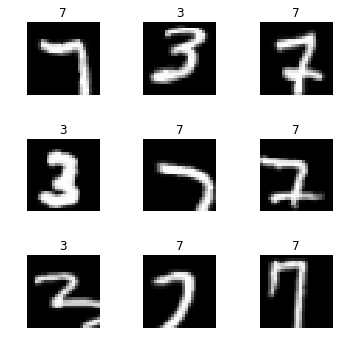

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

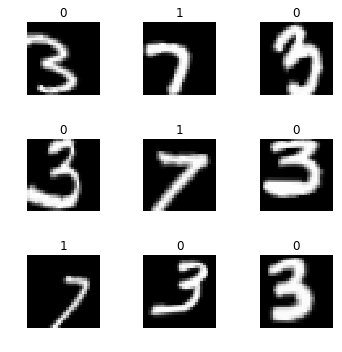

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']